# JLE Supplier Quality, Retention, and Learning-Curve Analysis
**By:** Ivanna Nguyen  

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

plt.rcParams['figure.figsize'] = (10,6)

In [17]:
# Excel file
excel_path = Path("/Users/yu/Downloads/Chapter 8 Case Data (3).xlsx")
assert excel_path.exists(), "Excel file not found"

In [18]:
# check sheets
xls = pd.ExcelFile(excel_path)
xls.sheet_names

['Defects after Delivery', 'Employee Retention', 'Engines']

In [19]:
# show first few rows from each sheet
sheets = {name: pd.read_excel(excel_path, sheet_name=name) for name in xls.sheet_names}
for name, df in sheets.items():
    print(f"=== {name} ===")
    print(df.head(), "\n")

=== Defects after Delivery ===
  Defects per million items received from suppliers  Unnamed: 1  Unnamed: 2  \
0                                             Month        2014        2015   
1                                           January         812         828   
2                                          February         810         832   
3                                             March         813         847   
4                                             April         823         839   

   Unnamed: 3  Unnamed: 4  Unnamed: 5  
0        2016        2017        2018  
1         824         682         571  
2         836         695         575  
3         818         692         547  
4         825         686         542   

=== Employee Retention ===
  Employee Retention    Unnamed: 1   Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0                NaN           NaN          NaN        NaN        NaN   
1           YearsPLE  YrsEducation  College GPA        Age     Gender   
2     

## 1. Supplier Defects — Clean, Model, Visualize
Tidy the `Defects after Delivery` sheet, fit a pre‑initiative trend, and compare the **actual** path to a **counterfactual** path that assumes the initiative never happened (initiative in **August 2015**).

In [29]:
def clean_defects(df):
    # first visible row contains 'Month, 2014, 2015, 2016, 2017, 2018'
    tidy = df.iloc[1:].copy()
    cols = ['Month'] + [str(int(x)) for x in df.iloc[0,1:].values if pd.notnull(x)]
    tidy.columns = ['Month'] + cols[1:]
    # reshape to long format
    long_df = tidy.melt(id_vars='Month', var_name='Year', value_name='DefectsPerMillion')
    long_df = long_df.dropna(subset=['Month','DefectsPerMillion'])
    # month order and time index
    month_order = {m:i for i,m in enumerate(
        ['January','February','March','April','May','June','July','August','September','October','November','December'], start=1)}
    long_df['MonthNum'] = long_df['Month'].map(month_order)
    long_df['Year'] = long_df['Year'].astype(int)
    long_df = long_df.sort_values(['Year','MonthNum']).reset_index(drop=True)
    start_year = long_df['Year'].min()
    long_df['t'] = (long_df['Year'] - start_year) * 12 + (long_df['MonthNum'] - 1) + 1
    return long_df

def analyze_defects(long_df, initiative_year=2015, initiative_month=8):
    # compute time index for initiative month
    t0 = long_df.loc[(long_df['Year']==initiative_year) & (long_df['MonthNum']==initiative_month), 't'].iloc[0]
    pre = long_df[long_df['t'] < t0]
    post = long_df[long_df['t'] >= t0]
    # fit linear trend on pre period
    X_pre = sm.add_constant(pre['t'])
    y_pre = pre['DefectsPerMillion']
    model = sm.OLS(y_pre, X_pre).fit()
    # predict counterfactual for post
    X_post = sm.add_constant(post['t'])
    post = post.copy()
    post['Counterfactual'] = model.predict(X_post)
    post['Improvement_vs_CF'] = post['Counterfactual'] - post['DefectsPerMillion']
    post['Improvement_pct'] = post['Improvement_vs_CF'] / post['Counterfactual']
    return model, t0, pre, post

defects_raw = sheets['Defects after Delivery']
defects_long = clean_defects(defects_raw)
def_model, t0, defects_pre, defects_post = analyze_defects(defects_long)

avg_improve = defects_post['Improvement_pct'].mean()
avg_improve

np.float64(0.22400806121606015)

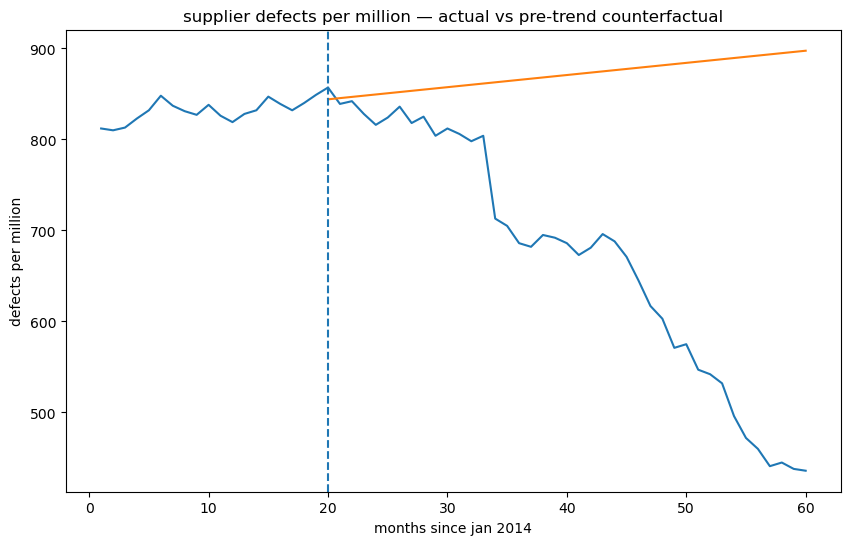

In [30]:
# plot: actual path vs counterfactual after initiative
plt.plot(defects_long['t'], defects_long['DefectsPerMillion'])
plt.plot(defects_post['t'], defects_post['Counterfactual'])
plt.axvline(t0, linestyle='--')
plt.title('supplier defects per million — actual vs pre‑trend counterfactual')
plt.xlabel('months since jan 2014')
plt.ylabel('defects per million')
plt.show()

## 2. Employee Retention — Multiple Regression
Target: `YearsPLE` (years with company)  

Predictors: `YrsEducation`, `College GPA`, `Age`

In [31]:
ret_raw = sheets['Employee Retention'].copy()
# header row is at index 1
ret_cols = ret_raw.iloc[1].tolist()
ret_df = ret_raw.iloc[2:].copy()
ret_df.columns = ret_cols
ret_df = ret_df[['YearsPLE','YrsEducation','College GPA','Age']].dropna()
ret_df = ret_df.astype({'YearsPLE':'float','YrsEducation':'float','College GPA':'float','Age':'float'})

X = sm.add_constant(ret_df[['YrsEducation','College GPA','Age']])
y = ret_df['YearsPLE']
ret_model = sm.OLS(y, X).fit()
ret_model.rsquared

np.float64(0.1502026772162086)

In [32]:
# coefficient table
ret_model.params

const          -2.737108
YrsEducation   -0.067054
College GPA     0.679981
Age             0.291536
dtype: float64

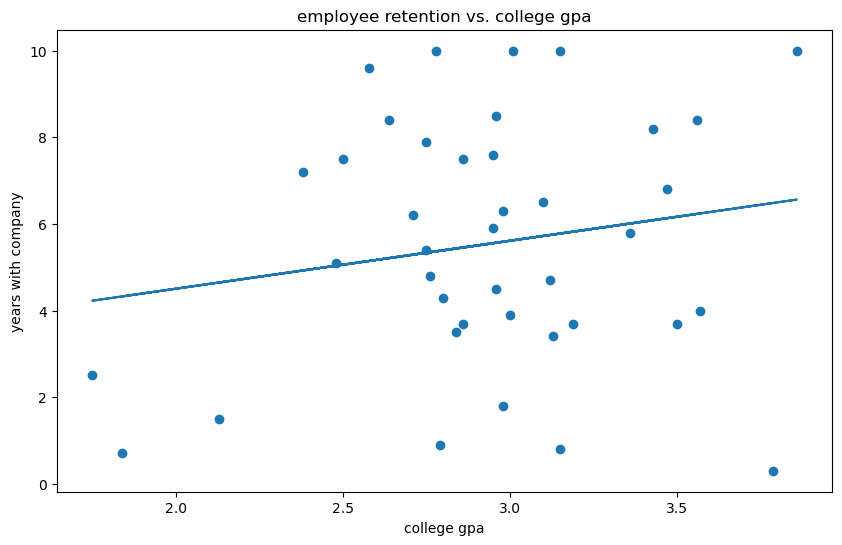

In [33]:
# GPA vs. tenure
plt.scatter(ret_df['College GPA'], ret_df['YearsPLE'])
X_gpa = sm.add_constant(ret_df['College GPA'])
yhat = sm.OLS(y, X_gpa).fit().predict(X_gpa)
plt.plot(ret_df['College GPA'], yhat)
plt.title('employee retention vs. college gpa')
plt.xlabel('college gpa')
plt.ylabel('years with company')
plt.show()

## 3. Engine Production — Learning Curve
Learning rate when output doubles = \(2^b\).

In [34]:
eng_raw = sheets['Engines'].copy()
eng_df = eng_raw.iloc[2:].copy()
eng_df.columns = ['Sample','ProductionTimeMin']
eng_df = eng_df.dropna()
eng_df['Sample'] = eng_df['Sample'].astype(int)
eng_df['ProductionTimeMin'] = pd.to_numeric(eng_df['ProductionTimeMin'])

eng_df['logN'] = np.log(eng_df['Sample'])
eng_df['logT'] = np.log(eng_df['ProductionTimeMin'])
X = sm.add_constant(eng_df['logN'])
y = eng_df['logT']
lc_model = sm.OLS(y, X).fit()

b = lc_model.params['logN']
learning_rate = float(2 ** b)
learning_rate

0.9346256674764905

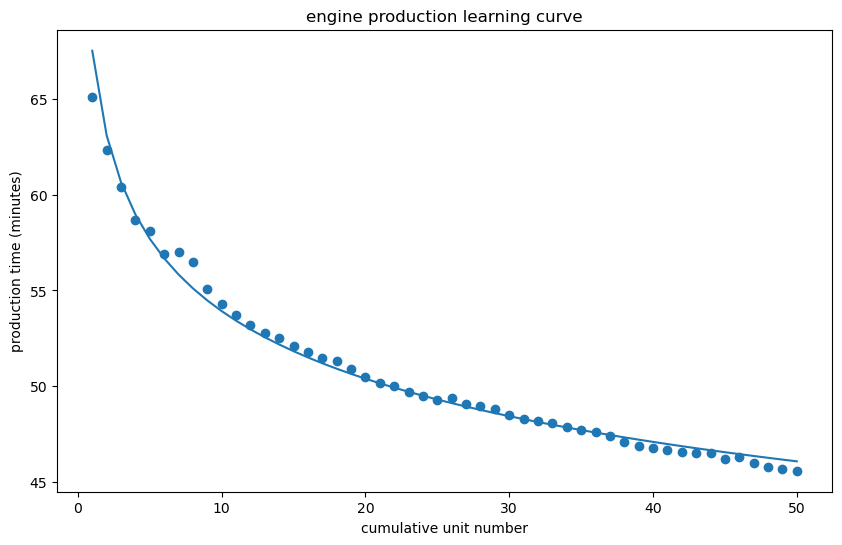

In [35]:
# learning curve in original units
plt.scatter(eng_df['Sample'], eng_df['ProductionTimeMin'])
yhat = np.exp(lc_model.predict(X))
plt.plot(eng_df['Sample'], yhat)
plt.title('engine production learning curve')
plt.xlabel('cumulative unit number')
plt.ylabel('production time (minutes)')
plt.show()

## 4. Clean Tables and Visuals

In [37]:
out_dir = Path('jle_outputs')
out_dir.mkdir(exist_ok=True)

defects_post.to_csv(out_dir / 'defects_actual_vs_counterfactual.csv', index=False)
ret_df.to_csv(out_dir / 'employee_retention_clean.csv', index=False)
eng_df.to_csv(out_dir / 'engines_clean.csv', index=False)

# 1) defects
plt.figure()
plt.plot(defects_long['t'], defects_long['DefectsPerMillion'])
plt.plot(defects_post['t'], defects_post['Counterfactual'])
plt.axvline(t0, linestyle='--')
plt.title('supplier defects per million — actual vs pre‑trend counterfactual')
plt.xlabel('months since jan 2014')
plt.ylabel('defects per million')
plt.tight_layout()
plt.savefig(out_dir / 'defects_actual_vs_counterfactual.png', dpi=220)
plt.close()

# 2) retention
plt.figure()
plt.scatter(ret_df['College GPA'], ret_df['YearsPLE'])
X_gpa = sm.add_constant(ret_df['College GPA'])
yhat = sm.OLS(ret_df['YearsPLE'], X_gpa).fit().predict(X_gpa)
plt.plot(ret_df['College GPA'], yhat)
plt.title('employee retention vs. college gpa')
plt.xlabel('college gpa')
plt.ylabel('years with company')
plt.tight_layout()
plt.savefig(out_dir / 'retention_vs_gpa.png', dpi=220)
plt.close()

# 3) learning curve
plt.figure()
plt.scatter(eng_df['Sample'], eng_df['ProductionTimeMin'])
yhat = np.exp(lc_model.predict(X))
plt.plot(eng_df['Sample'], yhat)
plt.title('engine production learning curve')
plt.xlabel('cumulative unit number')
plt.ylabel('production time (minutes)')
plt.tight_layout()
plt.savefig(out_dir / 'learning_curve.png', dpi=220)
plt.close()

summary = f"""average improvement vs. counterfactual after initiative: {defects_post['Improvement_pct'].mean():.1%}
retention model R^2: {ret_model.rsquared:.3f}
estimated learning rate (time drop when doubling output): {learning_rate:.3f}
"""
with open(out_dir / 'readme_numbers.txt', 'w') as f:
    f.write(summary)

sorted([p.name for p in out_dir.iterdir()])

['defects_actual_vs_counterfactual.csv',
 'defects_actual_vs_counterfactual.png',
 'employee_retention_clean.csv',
 'engines_clean.csv',
 'learning_curve.png',
 'readme_numbers.txt',
 'retention_vs_gpa.png']